In [1]:
import numpy as np
import math
import sys
import mpmath
sys.modules['sympy.mpmath'] = mpmath
from openmm.unit import AVOGADRO_CONSTANT_NA, BOLTZMANN_CONSTANT_kB
from openmm.unit import kelvin, bar, litre, kilojoule_per_mole, mole, nanometer, angstrom, kilocalorie_per_mole,molar,molal
from openmm.unit import Quantity, Unit
import sympy as sp
from sympy import symbols, Function, log, Sum
from sympy.abc import x, y, z
import scipy.integrate
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.optimize import root

## Analytical solution

In [2]:
R = BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA

def calc_solute_conc(C_max : Quantity, potential : Quantity, T : Quantity=300*kelvin) -> Quantity:
    '''Determine solute concentration'''
    return C_max * np.exp(-potential / (R * T))

def potential_harmonic(z : Quantity, k : Quantity) -> Quantity:
    '''Get simple quadratic harmonic potential'''
    return (k * z**2) / 2


In [3]:
N = 217

L_z = 14.4 * nanometer
z = np.linspace(-L_z._value/2, L_z._value/2, num=N)

C_max = 3.26 * mole* litre**-1
k = 0.68095403 * kilojoule_per_mole / nanometer**2

T = 300 * kelvin

15.636989083026837 mol/L


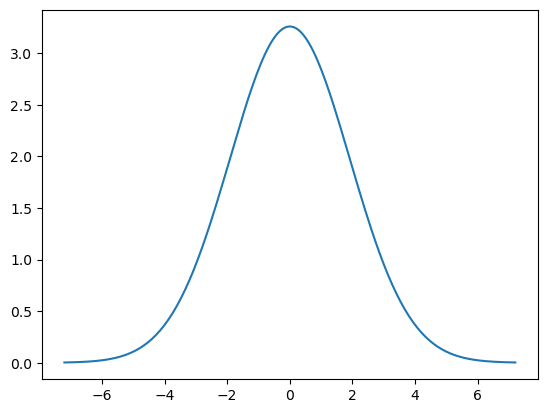

In [4]:
pots = potential_harmonic(z*nanometer, k=k)

C_s = calc_solute_conc(C_max, potential=pots, T=T)
plt.plot(z, C_s)

I = scipy.integrate.simpson(C_s, x=z) * C_s.unit
print(I)

## Numerical Solution

In [5]:
def calc_C_max_from_spring_const(k : Quantity, box_dims : np.ndarray, N_ions : int, T : Quantity=300*kelvin) -> Quantity:
    Lx, Ly, Lz = box_dims
    A = Lx * Ly
    K = k / (2 * R * T)
    Ksq = np.sqrt(K._value) * (1*K.unit).sqrt()

    Cmax = (N_ions/A * Ksq) / (np.sqrt(np.pi) * erf(Lz / (2 * Ksq)))
    Cmax = (Cmax / AVOGADRO_CONSTANT_NA).in_units_of(molar)

    return Cmax

Cmax_target = 3.26 * molar

def Cmax_for_roots(k : float) -> float:
    return calc_C_max_from_spring_const(
        k * kilojoule_per_mole/nanometer**2,
        box_dims=np.array([4.8, 4.8, 14.4]) * nanometer,
        N_ions=217,
        T=300*kelvin
    ) - Cmax_target

In [6]:
soln = root(lambda k : Cmax_for_roots(k)._value, np.float64(0.0))
print('Estimated force constant: ',soln.x,"\n")

Estimated force constant:  [0.68095403] 



/home/bamo6610/miniconda3/envs/calculus/lib/python3.10/site-packages/openmm/unit/quantity.py:414: RuntimeWarning: divide by zero encountered in reciprocal
  return self * pow(other, -1.0)


In [7]:
Cmax = calc_C_max_from_spring_const(
    k=0.68095403 * kilojoule_per_mole/nanometer**2,
    box_dims=np.array([48.0, 48.0, 144.0]) * angstrom,
    N_ions=217,
    T=300*kelvin
)
print('Cmax from spring constant: ',Cmax)

Cmax from spring constant:  3.2599999984944974 M


In [8]:
Cmax=Cmax_for_roots(0.68095403)
print('Cmax for root: ',Cmax)

Cmax for root:  -1.5055037216882283e-09 M
